# Data Science Graph Algorithms

In this notebook we:
- load in CSV file data with neo4j
- run the following graph algorithms:
    - Harmonic Centrality
    - PageRank
    - Louvain Modularity
- interpret results

For ease of analysis, we exclude countries with zero refugee flow (e.g., tiny Caribbean island nations)

First, we import some of the commands from previous labs: 

In [11]:
import neo4j

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

In [12]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))

In [13]:
session = driver.session(database="neo4j")

In [14]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)

In [15]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

In [16]:
def my_neo4j_nodes_relationships():
    "print all the nodes and relationships"
   
    print("-------------------------")
    print("  Nodes:")
    print("-------------------------")
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    display(df)
    
    print("-------------------------")
    print("  Relationships:")
    print("-------------------------")
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    display(df)
    
    density = (2 * number_relationships) / (number_nodes * (number_nodes - 1))
    
    print("-------------------------")
    print("  Density:", f'{density:.1f}')
    print("-------------------------")
    

# Loading Data into Neo4j

Data info

|variable          |class     |description       |
|:-----------------|:---------|:-----------------|
|year              |double    |The year.              |
|coo_name          |character |Country of origin name.        |
|coo               |character |Country of origin UNHCR code.   |
|coo_iso           |character |Country of origin ISO code.  |
|coa_name          |character |Country of asylum name.    |
|coa               |character |Country of asylum UNHCR code.  |
|coa_iso           |character |Country of asylum ISO code.    |
|refugees          |double    |The number of refugees.   |
|asylum_seekers    |double    |The number of asylum-seekers.  |
|returned_refugees |double    |The number of returned refugees. |
|idps              |double    |The number of internally displaced persons.     |
|returned_idps     |double    |The number of returned internally displaced persons.  |
|stateless         |double    |The number of stateless persons.  |
|ooc               |double    |The number of others of concern to UNHCR.   |
|oip               |double    |The number of other people in need of international protection.     |
|hst               |double    |The number of host community members.     |

In [17]:
def create_graph(year, refugee_min=1):
    """
    Loads CSV file for a specific year (files named populationXXXX.csv).
    refugee_min = lower limit of refugees to include (default 1)
    """
    my_neo4j_wipe_out_database()

    query = f"""
        LOAD CSV WITH HEADERS FROM 'file:///population{year}.csv' AS row
        MERGE (origin:Country {{iso_code: row.coo_iso, name: row.coo_name}})
        MERGE (asylum:Country {{iso_code: row.coa_iso, name: row.coa_name}})

        WITH row, origin, asylum
        WHERE toInteger(row.refugees) >= {refugee_min}
        CREATE (origin)-[:REFUGEE_FLOW {{
            year: toInteger(row.year),
            refugees: toInteger(row.refugees),
            asylum_seekers: toInteger(row.asylum_seekers),
            idps: toInteger(row.idps)
        }}]->(asylum)
        """

    session.run(query)

**An important note**

For the following analysis, we use the data science graph algorithms in two ways:
1. Origin --> Asylum (examine influence of countries that _create_ refugees)
2. Asylum --> Origin (examine influence of countries that _receieve_ refugees)

We run an example query for each direction below on the 2010 data.

In [20]:
create_graph(2010, refugee_min=1)

In [21]:
#Example query for total number of refugees/asylum seekers from countries

query = """
MATCH (n)-[r]->(b)
RETURN n.name AS origin_name, 
       n.iso_code AS origin_iso_code,
       SUM(toInteger(r.refugees)) as total_refugees,
       SUM(toInteger(r.asylum_seekers)) as total_asylum_seekers
ORDER BY total_refugees DESC
LIMIT 10
"""

my_neo4j_run_query_pandas(query)

,origin_name,origin_iso_code,total_refugees,total_asylum_seekers
0,Afghanistan,AFG,3054699,35131
1,Iraq,IRQ,1683576,29826
2,Somalia,SOM,770141,22583
3,Dem. Rep. of the Congo,COD,476691,43017
4,Myanmar,MMR,415662,22234
5,Colombia,COL,395579,60066
6,Sudan,SDN,387265,23608
7,Viet Nam,VNM,338707,1037
8,Eritrea,ERI,222457,13496
9,China,CHN,184601,7694


In [22]:
#Example query for total number of refugees/asylum INCOMING to a country

query = """

MATCH (origin)-[flow]->(asylum)
RETURN asylum.name AS asylum_name,
       asylum.iso_code AS asylum_iso_code,
       SUM(toInteger(flow.refugees)) AS total_refugees_incoming,
       SUM(toInteger(flow.asylum_seekers)) AS total_asylum_seekers_incoming
ORDER BY total_refugees_incoming DESC
LIMIT 10
"""

my_neo4j_run_query_pandas(query)

,asylum_name,asylum_iso_code,total_refugees_incoming,total_asylum_seekers_incoming
0,Pakistan,PAK,1900619,2088
1,Iran (Islamic Rep. of),IRN,1073363,1767
2,Syrian Arab Rep.,SYR,1005471,2364
3,Germany,DEU,594250,51930
4,Jordan,JOR,450908,2099
5,Kenya,KEN,402891,27957
6,Chad,TCD,347931,105
7,China,CHN,300984,115
8,United States of America,USA,264505,6276
9,United Kingdom of Great Britain and Northern I...,GBR,238133,14880


# Harmonic Centrality

We run the Harmonic Centrality algorithm on the data over multiple years.

The analyze_refugee_centrality function does the following:
1. Load in data using the create_graph function defined above
2. Ensures the correct graph orientation
3. Stores Harmonic Centrality results in a pandas dataframe.

Harmonic Centrality measures a node's (country) importance in a network based on the reciprocal shortest path distances to all other nodes. Therefore a country with a high harmonic centrality score is "close" to many other nodes (weighted by number of refugees sent).

!!! **Note the direction interpretation:** !!!

**Natural**: Origin --> Asylum: a high degree of centrality means the country has ability to send many refugees to many countries

**Revrese**: Asylum --> Origin: a high degree of centrality means the country acts as a destination/transit hub.

In [23]:
def analyze_refugee_centrality(year, refugee_min=1, direction='natural'):
    """
    Analyze refugee flow centrality (harmonic centrality) for a specific year with configurable direction
    Parameters:
    - year: Dataset year to analyze
    - refugee_min: Minimum refugee count to include (default 1)
    - direction: 'natural' (origin->asylum) or 'reverse' (asylum->origin)
    Returns: pandas dataframe w/ centrality results
    """
    #load in data with csv
    create_graph(year, refugee_min=refugee_min)
    
    #clear as needed
    session.run("CALL gds.graph.drop('refugee_graph', false) YIELD graphName")
    
    # natural = origin-->asylum (for looking at countries that send the most refugees) 
    # reverse = asylum-->origin (for looking at transit/destination countries) 
    orientation = 'NATURAL' if direction.lower() == 'natural' else 'REVERSE'
    project_query = f"""
    CALL gds.graph.project(
        'refugee_graph',
        'Country',
        {{REFUGEE_FLOW: {{
            orientation: '{orientation}',
            properties: 'refugees'
        }}}}
    )
    """
    session.run(project_query)

    centrality_query = """
    CALL gds.degree.stream('refugee_graph', {
        relationshipWeightProperty: 'refugees'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS country,
           gds.util.asNode(nodeId).iso_code as iso_code,
           score AS harmonic_centrality
    ORDER BY harmonic_centrality DESC, country
    """
    
    return my_neo4j_run_query_pandas(centrality_query)

In [17]:
#natural direction: Origin --> asylum
analyze_refugee_centrality(year=2010, refugee_min=1, direction='natural').head()

,country,iso_code,harmonic_centrality
0,Afghanistan,AFG,3054699.0
1,Iraq,IRQ,1683576.0
2,Somalia,SOM,770141.0
3,Dem. Rep. of the Congo,COD,476691.0
4,Myanmar,MMR,415662.0


In [18]:
#reverse direction: Asylum --> origin (helps see transit/destination countries)
analyze_refugee_centrality(year=2010, refugee_min=1, direction='reverse').head()

,country,iso_code,harmonic_centrality
0,Pakistan,PAK,1900619.0
1,Iran (Islamic Rep. of),IRN,1073363.0
2,Syrian Arab Rep.,SYR,1005471.0
3,Germany,DEU,594250.0
4,Jordan,JOR,450908.0


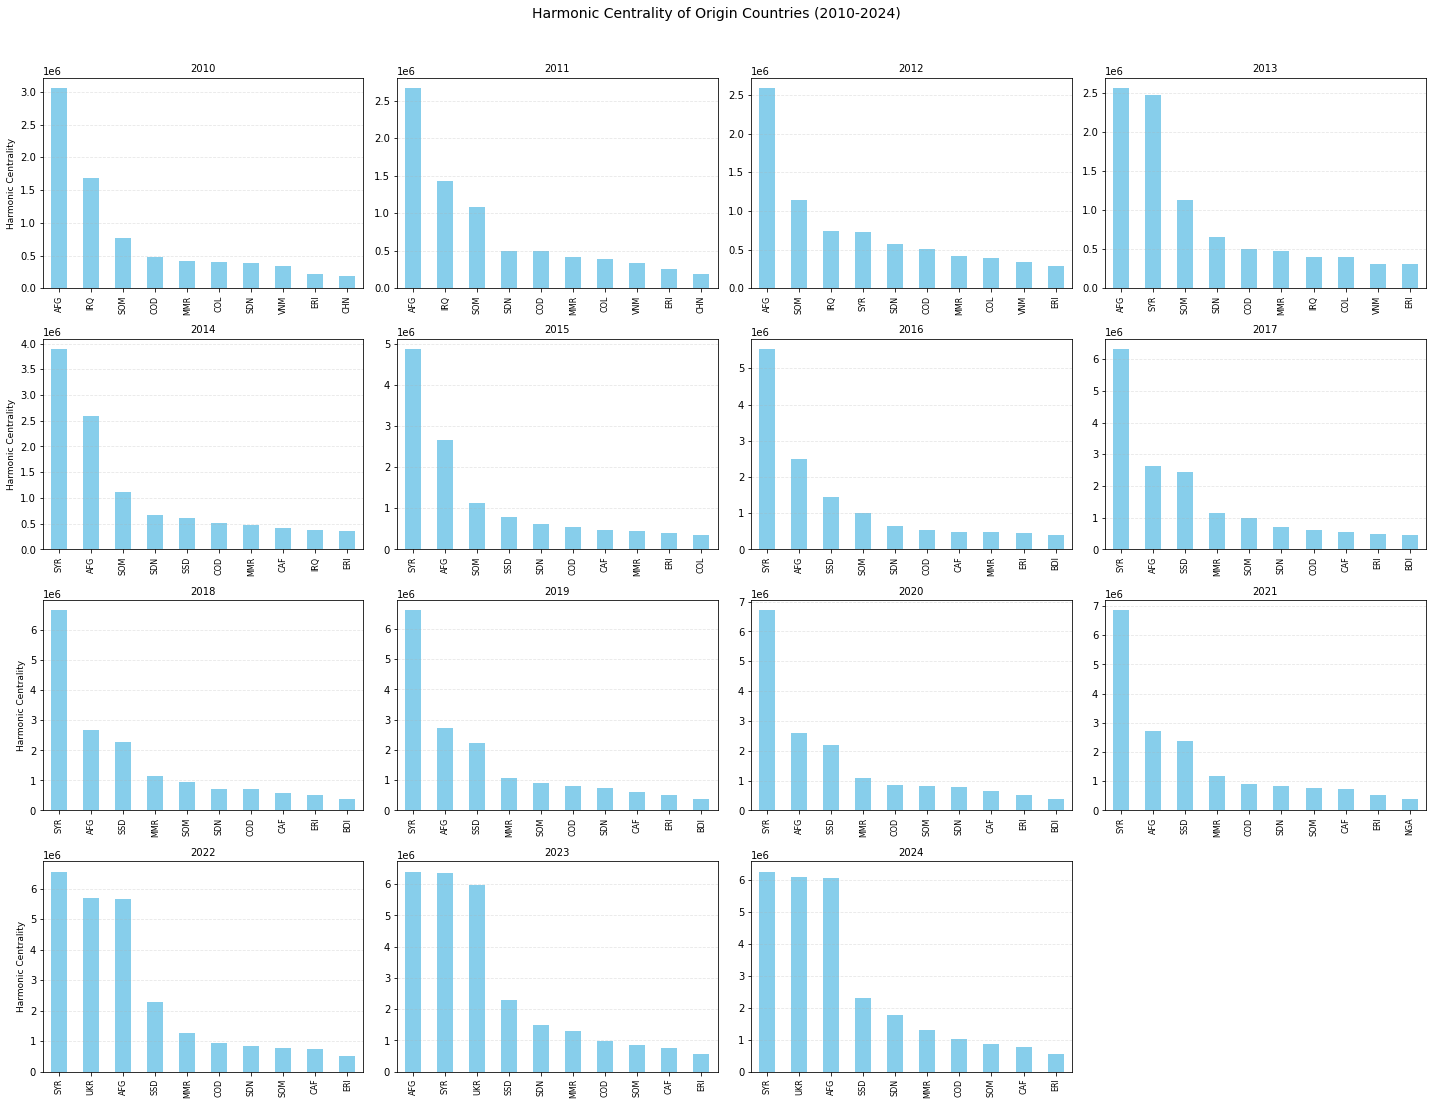

In [29]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
fig.suptitle('Harmonic Centrality of Origin Countries (2010-2024)', y=1.02, fontsize=14)
plt.subplots_adjust(hspace=0.5, wspace=0.3)

axes = axes.flatten()

for idx, year in enumerate(range(2010, 2025)):
    ax = axes[idx]

    df = analyze_refugee_centrality(year, direction='natural')
    top_10 = df[:10]

    bars = top_10.plot.bar(x='iso_code', y='harmonic_centrality', 
                          ax=ax, legend=False, color='skyblue')
    ax.set_title(f'{year}', fontsize=10)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.set_xlabel('')

    ax.yaxis.grid(True, linestyle='--', alpha=0.3)

    #1st column y label only
    if idx % 4 == 0:
        ax.set_ylabel("Harmonic Centrality", fontsize=9)

for idx in range(len(range(2010, 2025)), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

**Interpretation**

Afghanistan and Syria are both the top countries, but notice that Syria has significantly higher Harmonic Centrality than Afghanistan. Part of the explanation could be the ease for Syrian immigrants to migrate to more countries than Afghanistan. Afghanistan tends to send most of its refugees to Pakistan, which hurts its harmonic centrality score.

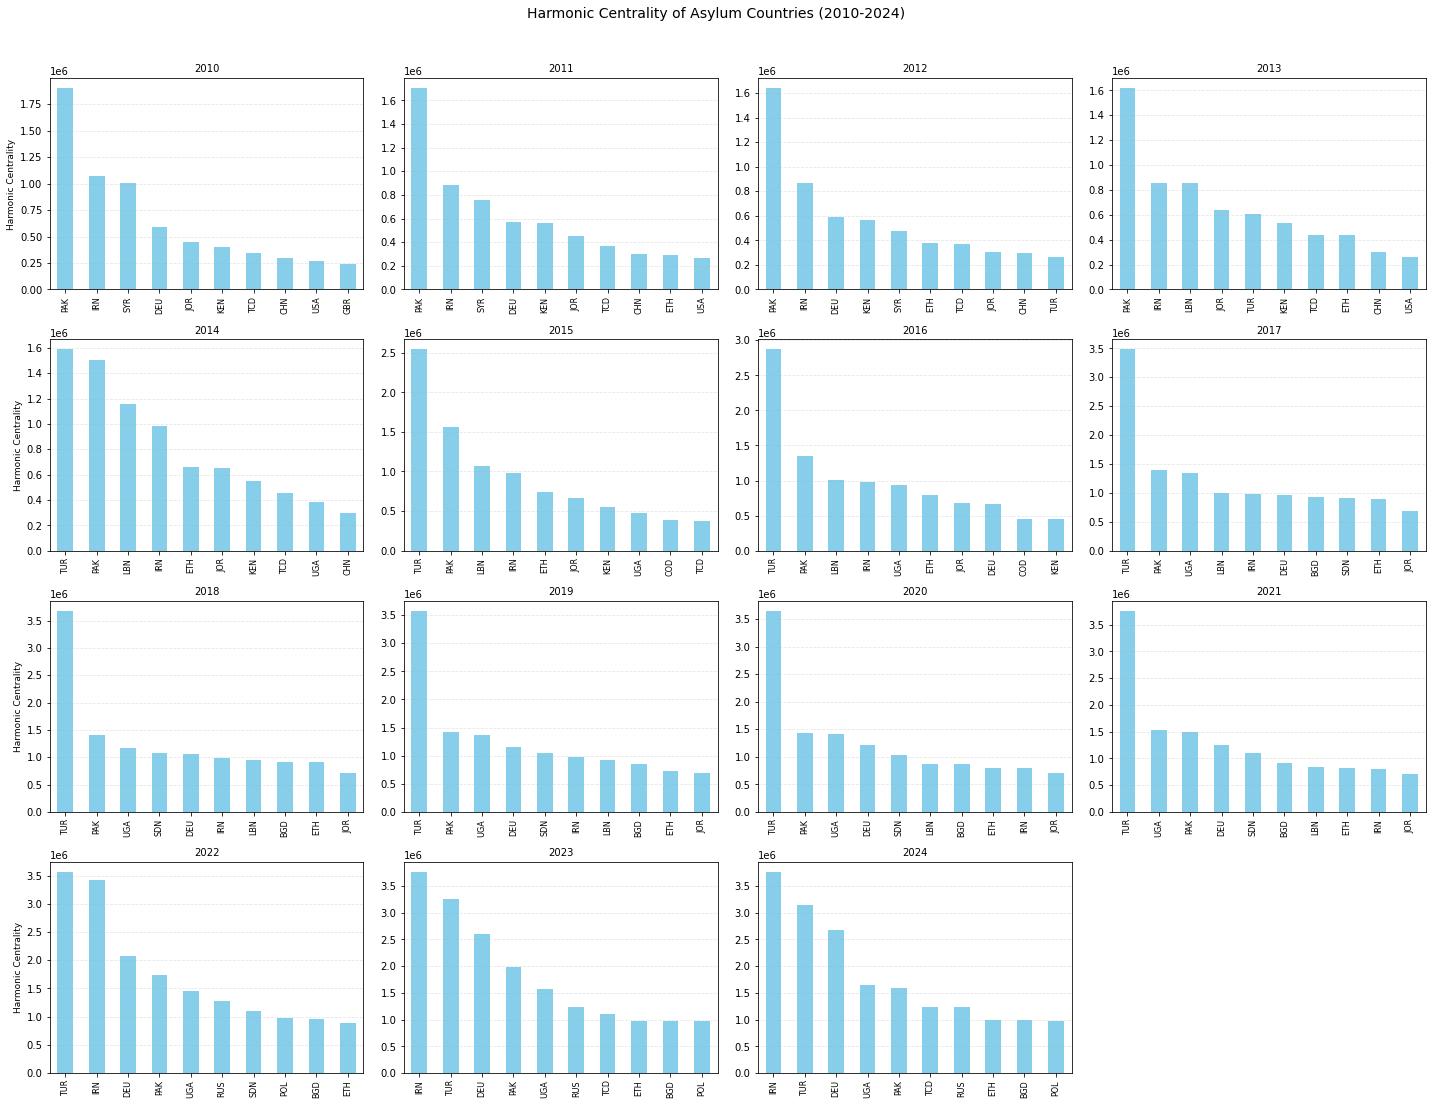

In [30]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
fig.suptitle('Harmonic Centrality of Asylum Countries (2010-2024)', y=1.02, fontsize=14)
plt.subplots_adjust(hspace=0.5, wspace=0.3)

axes = axes.flatten()

for idx, year in enumerate(range(2010, 2025)):
    ax = axes[idx]

    df = analyze_refugee_centrality(year, direction='reverse')
    top_10 = df[:10]

    bars = top_10.plot.bar(x='iso_code', y='harmonic_centrality', 
                          ax=ax, legend=False, color='skyblue')
    ax.set_title(f'{year}', fontsize=10)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.set_xlabel('')

    ax.yaxis.grid(True, linestyle='--', alpha=0.3)

    #1st column y label only
    if idx % 4 == 0:
        ax.set_ylabel("Harmonic Centrality", fontsize=9)

for idx in range(len(range(2010, 2025)), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

**Interpretation**

For asylum countries, Turkey consistently remains in the top countries from 2014 onwards.

Notice in 2022 that Iran jumps into second place and becomes the number 1 in 2023, 2024. In 2022, Iran experienced a substantial increase in refugees from Afghanistan due to both new arrivals and formal recognition of previously undocumented Afghans.


# PageRank

We now create a similar function to the above, but now running PageRank.

Note that PageRank requires additional parameters:
- damping: probability the random surfer will follow the edges (refugee flows). Higher => keeps more of graph's structure
- maxIterations: max num of times to update the PageRank scores. Higher => better accuracy but more compute

We interpret the PageRank scores for each direction as follows:
- **Natural**: origin --> asylum || a country gains pagerank if it receives refugees from influential origins
- **Reverse**: asylum --> origin || a country gains pagerank if it "voted for" by influential asylums

In [36]:
def analyze_refugee_pagerank(year, refugee_min=1, direction='natural', 
                             damping=0.85, maxIterations=100):
    """
    Analyze refugee flow with pagerank for a specific year with configurable direction
    Parameters:
    - year: Dataset year to analyze
    - refugee_min: Minimum refugee count to include (default 1)
    - direction: 'natural' (origin->asylum) or 'reverse' (asylum->origin)
    - 
    Returns pandas dataframe w/ pagerank results
    """
    create_graph(year, refugee_min=refugee_min)
    session.run("CALL gds.graph.drop('pagerank_graph', false) YIELD graphName")
    
    #specify direction
    orientation = 'NATURAL' if direction.lower() == 'natural' else 'REVERSE'
    project_query = f"""
    CALL gds.graph.project(
        'pagerank_graph',
        'Country',
        {{REFUGEE_FLOW: {{
            orientation: '{orientation}',
            properties: 'refugees'
        }}}}
    )
    """
    session.run(project_query)
    
    #pagerank w/ refugee counts as weights
    pagerank_query = f"""
    CALL gds.pageRank.stream('pagerank_graph', {{
        maxIterations: {maxIterations},
        dampingFactor: {damping},
        relationshipWeightProperty: 'refugees'
    }})
    YIELD nodeId, score
    RETURN 
        gds.util.asNode(nodeId).name AS country,
        gds.util.asNode(nodeId).iso_code as iso_code,
        score AS pagerank_score
    ORDER BY pagerank_score DESC
    """
    return my_neo4j_run_query_pandas(pagerank_query)

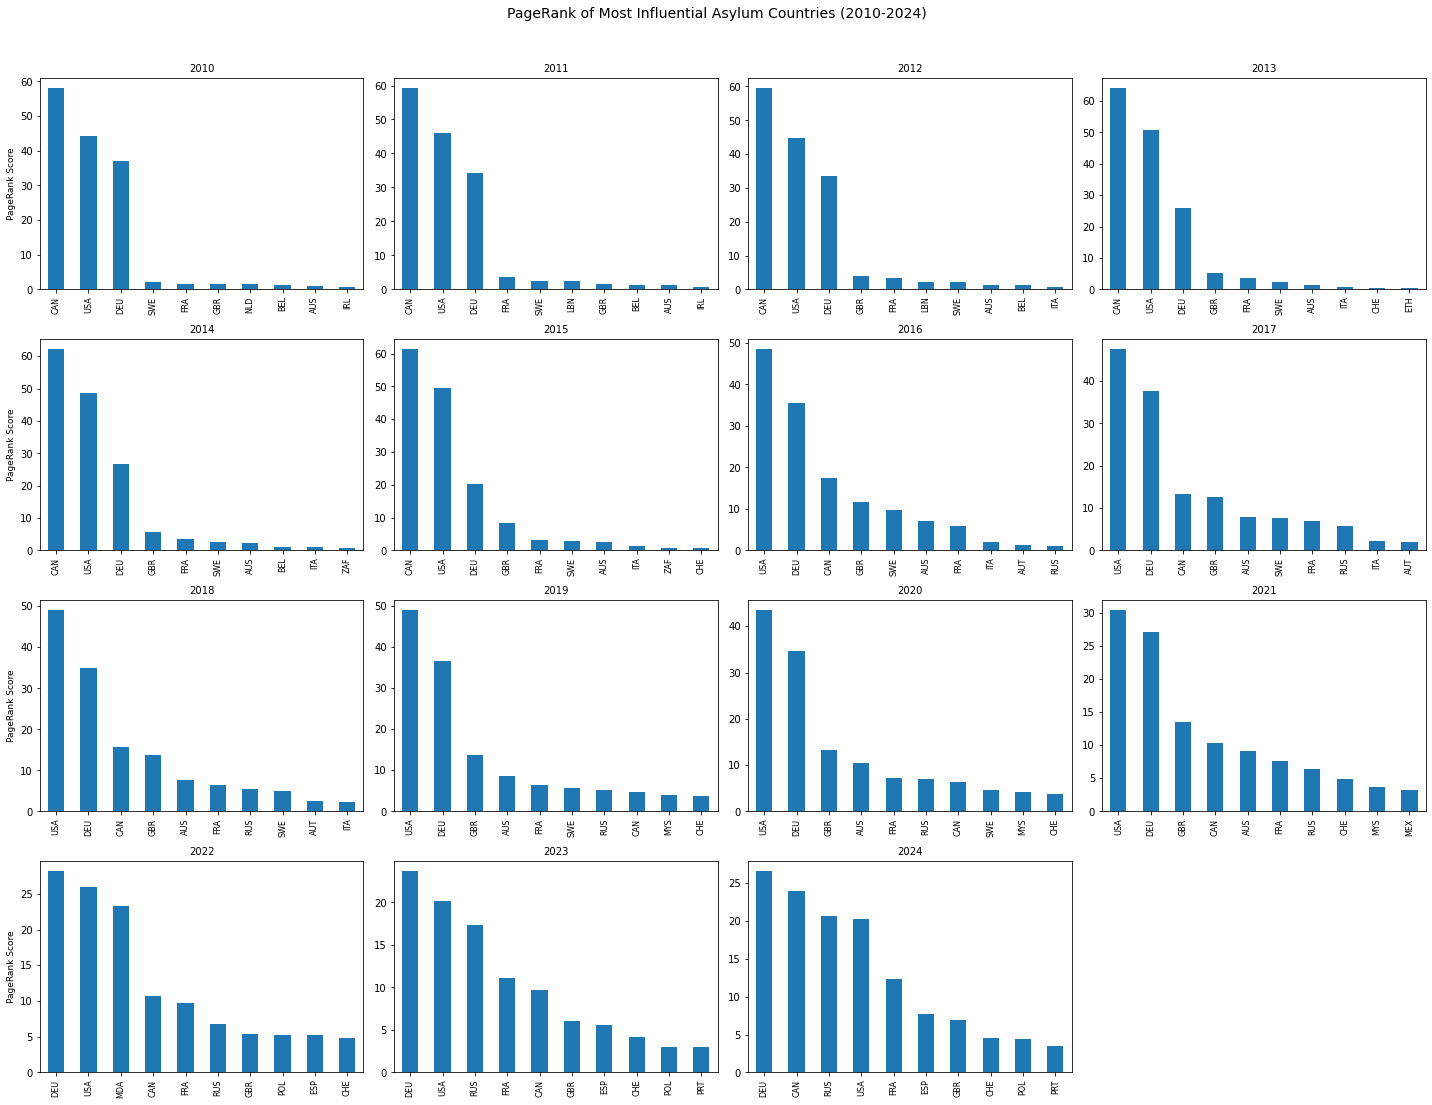

In [33]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
fig.suptitle('PageRank of Most Influential Asylum Countries (2010-2024)', y=1.02, fontsize=14)
plt.subplots_adjust(hspace=0.5, wspace=0.3)

axes = axes.flatten()

for idx, year in enumerate(range(2010, 2025)):
    ax = axes[idx]
    
    df = analyze_refugee_pagerank(year, direction='natural')
    top_10 = df[:10]
    
    top_10.plot.bar(x='iso_code', y='pagerank_score', ax=ax, legend=False)
    ax.set_title(f'{year}', fontsize=10)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.set_xlabel('')
    
    # onlyadd ylabel to first
    if idx % 4 == 0:
        ax.set_ylabel("PageRank Score", fontsize=9)

for idx in range(len(range(2010, 2025)), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

**Interpretation of Pagerank Asylum 2010-2024**

Note that interestingly Canada was most influential (over USA) from 2011 - 2015. Note that this isn't a reflection of raw refugee numbers, but also combines WHICH countries it took refugees from. The US refugee population is probably more diluted.

USA is the most influential until 2022, when it is overtaken by Germany. In 2021, USA pulled out of afghanistan. In 2022, Russia invaded Ukraine, many of whom fled to Germany, explaining why Germany becomes the number 1 spot.


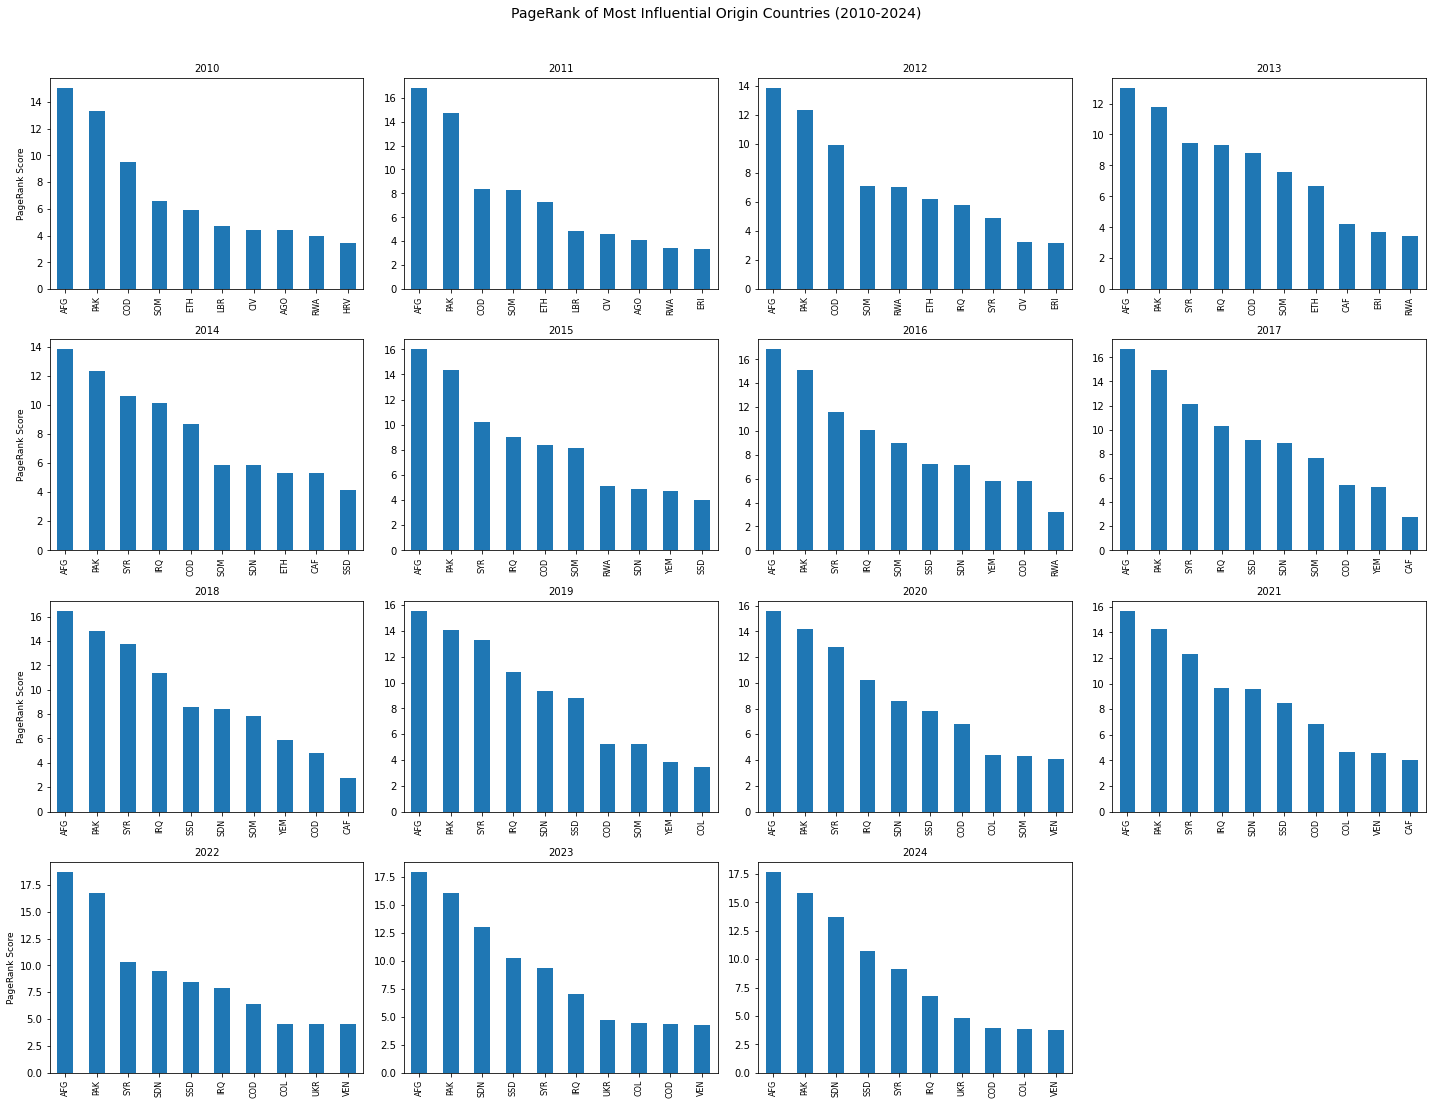

In [34]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
fig.suptitle('PageRank of Most Influential Origin Countries (2010-2024)', y=1.02, fontsize=14)
plt.subplots_adjust(hspace=0.5, wspace=0.3)

axes = axes.flatten()

for idx, year in enumerate(range(2010, 2025)):
    ax = axes[idx]
    
    df = analyze_refugee_pagerank(year, direction='reverse')
    top_10 = df[:10]
    
    top_10.plot.bar(x='iso_code', y='pagerank_score', ax=ax, legend=False)
    ax.set_title(f'{year}', fontsize=10)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.set_xlabel('')
    
    # onlyadd ylabel to first
    if idx % 4 == 0:
        ax.set_ylabel("PageRank Score", fontsize=9)

for idx in range(len(range(2010, 2025)), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

**Interpretation of PageRank Origin 2010-2024**

Perhaps unsurprisingly we see that Afghanistan ranks number 1 every year. Notice also that Pakistan ranks number 2. Even though Pakistan does produce many Pakistani refugees, they host millions of Afghan refugees who then flee to other countries, explaining the high Pakistan rank.

Other notable events from the chart:
- 2022: Ukraine appears in the top 10 due to the Ukraine war
- 2023: Sudan and South Sudan both rise into the top 5 due to the Sudan Refugee Crisis (the largest displacement crisis of the year)

**Examining Canada vs USA switchover in 2015-2016**

Below we briefly investigate the switch from Canada to USA in the PageRank #1 spot 2015-2016.

Initially, we expected USA to be the most influential due to its size and reach throughout the world. 

In [92]:
df_2015 = pd.read_csv("data/population2015.csv")
df_2016 = pd.read_csv("data/population2016.csv")

cols = ['year', 'coo_name', 'coo', 'coo_iso',
        'coa_name', 'coa', 'coa_iso', 'refugees']
df_2015 = df_2015[cols]
df_2016 = df_2016[cols]

df_2015.sort_values(by='refugees', ascending=False, inplace=True)
df_2016.sort_values(by='refugees', ascending=False, inplace=True)

df_2015_can = df_2015[df_2015['coa_iso']=="CAN"]
df_2015_usa = df_2015[df_2015['coa_iso']=="USA"]

df_2016_can = df_2016[df_2016['coa_iso']=="CAN"]
df_2016_usa = df_2016[df_2016['coa_iso']=="USA"]

#pagerank for 2015, 2016
pagerank_2015 = analyze_refugee_pagerank(2015, direction='natural')
pagerank_2016 = analyze_refugee_pagerank(2016, direction='natural')

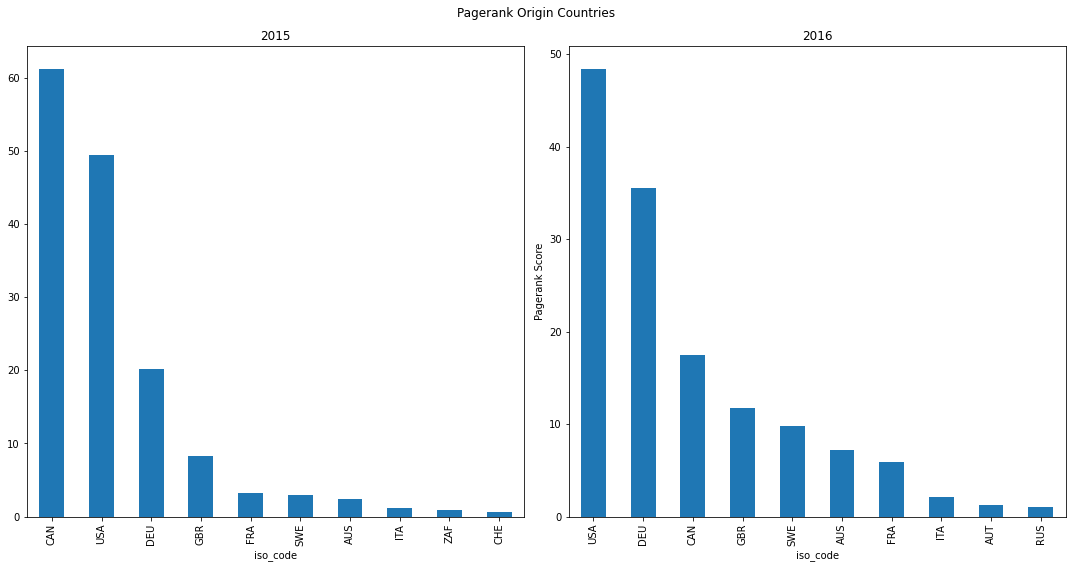

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(15,8))
pagerank_2015[:10].plot.bar(x='iso_code', y='pagerank_score', ax=axes[0], legend=False)
pagerank_2016[:10].plot.bar(x='iso_code', y='pagerank_score', ax=axes[1], legend=False)
axes[0].set_title('2015')
axes[1].set_title('2016')
plt.ylabel('Pagerank Score')
plt.suptitle("Pagerank Origin Countries")
plt.tight_layout()
plt.show()

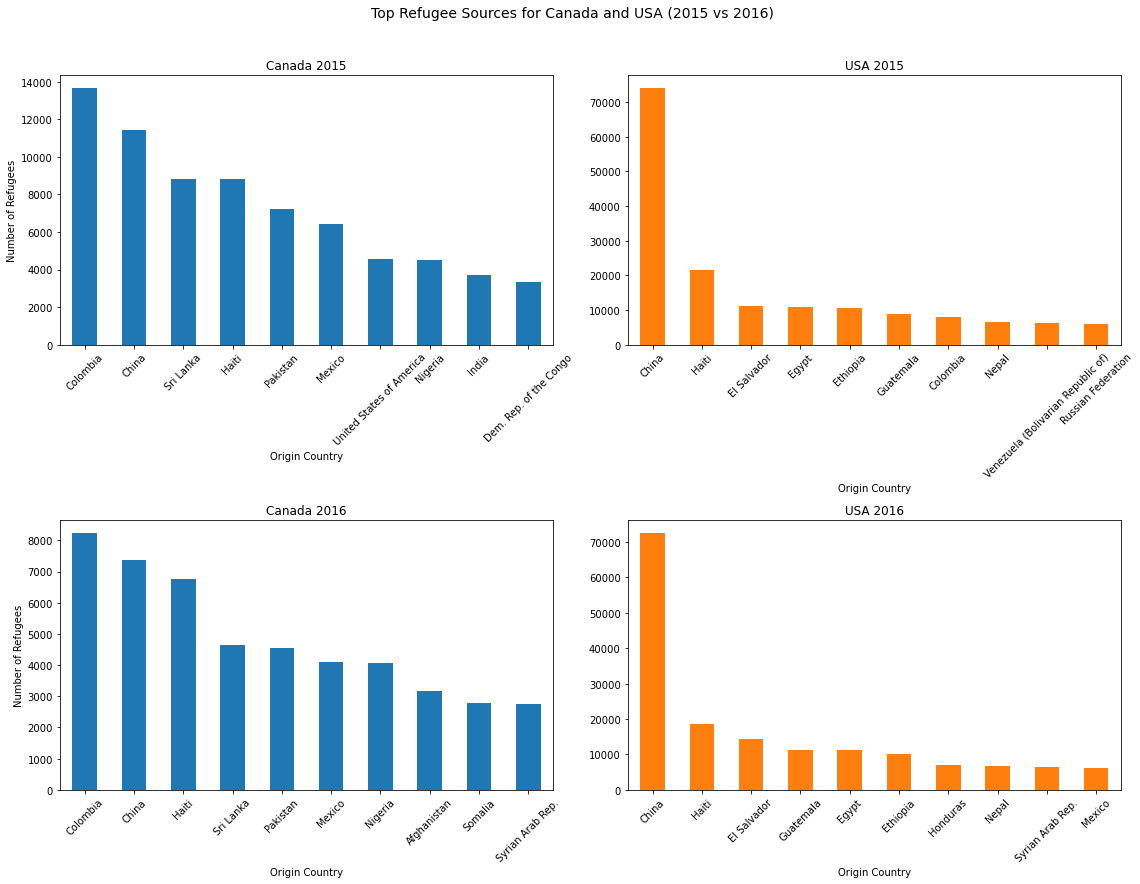

In [96]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 2015 Data
df_2015_can[:10].plot.bar(x='coo_name', y='refugees', ax=axes[0,0], color='#1f77b4', legend=False)
df_2015_usa[:10].plot.bar(x='coo_name', y='refugees', ax=axes[0,1], color='#ff7f0e', legend=False)

# 2016 Data
df_2016_can[:10].plot.bar(x='coo_name', y='refugees', ax=axes[1,0], color='#1f77b4', legend=False)
df_2016_usa[:10].plot.bar(x='coo_name', y='refugees', ax=axes[1,1], color='#ff7f0e', legend=False)

for row, year in enumerate([2015, 2016]):
    for col, country in enumerate(['Canada', 'USA']):
        axes[row,col].set_title(f"{country} {year}")
        axes[row,col].tick_params(axis='x', rotation=45)
        axes[row,col].set_xlabel('Origin Country')
        if col == 0:
            axes[row,col].set_ylabel('Number of Refugees')

plt.suptitle("Top Refugee Sources for Canada and USA (2015 vs 2016)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

Notice: in 2015, Canada was receiving many refugees from USA (USA acts as an intermediary), but in 2016 this stopped. (Possibly for political reasons).

Since the USA is such an influential country, it likely boosts Canada's score significantly. What would happen if we severed the USA-Canada relationship in the graph and ran PageRank?

In [98]:
#number of refugess
print("Number of refugees received")
print(" -- 2015 -- ")
print(f"Canada: {df_2015_can['refugees'].sum()}")
print(f"USA: {df_2015_usa['refugees'].sum()}")


print("\n -- 2016 -- ")
print(f"Canada: {df_2016_can['refugees'].sum()}")
print(f"USA: {df_2016_usa['refugees'].sum()}")

Number of refugees received
 -- 2015 -- 
Canada: 135890
USA: 273198

 -- 2016 -- 
Canada: 97322
USA: 272963


**Let's now try running PageRank, but we sever the USA-Canada relationship**

In [99]:
def pagerank_no_usa(year, refugee_min=1, direction='natural', 
                             damping=0.85, maxIterations=100):
    my_neo4j_wipe_out_database()
    
    #take out USA
    query = f"""
    LOAD CSV WITH HEADERS FROM 'file:///population{year}.csv' AS row
    MERGE (origin:Country {{iso_code: row.coo_iso, name: row.coo_name}})
    MERGE (asylum:Country {{iso_code: row.coa_iso, name: row.coa_name}})

    WITH row, origin, asylum
    WHERE toInteger(row.refugees) >= {refugee_min}
    AND NOT (
        origin.iso_code = 'USA'  // Filter out USA origin
        AND asylum.iso_code = 'CAN'  // Filter out Canada destination
    )
    CREATE (origin)-[:REFUGEE_FLOW {{
        year: {year},
        refugees: toInteger(row.refugees),
        asylum_seekers: toInteger(row.asylum_seekers),
        idps: toInteger(row.idps)
    }}]->(asylum)
    """

    session.run(query)
    session.run("CALL gds.graph.drop('pagerank_graph', false) YIELD graphName")
    
    orientation = 'NATURAL' if direction.lower() == 'natural' else 'REVERSE'
    project_query = f"""
    CALL gds.graph.project(
        'pagerank_graph',
        'Country',
        {{REFUGEE_FLOW: {{
            orientation: '{orientation}',
            properties: 'refugees'
        }}}}
    )
    """
    session.run(project_query)
    
    #pagerank w/ refugee counts as weights
    pagerank_query = f"""
    CALL gds.pageRank.stream('pagerank_graph', {{
        maxIterations: {maxIterations},
        dampingFactor: {damping},
        relationshipWeightProperty: 'refugees'
    }})
    YIELD nodeId, score
    RETURN 
        gds.util.asNode(nodeId).name AS country,
        gds.util.asNode(nodeId).iso_code as iso_code,
        score AS pagerank_score
    ORDER BY pagerank_score DESC
    """
    return my_neo4j_run_query_pandas(pagerank_query)


In [100]:
no_usa_2015 = pagerank_no_usa(2015, direction='natural')
no_usa_2016 = pagerank_no_usa(2016, direction='natural')

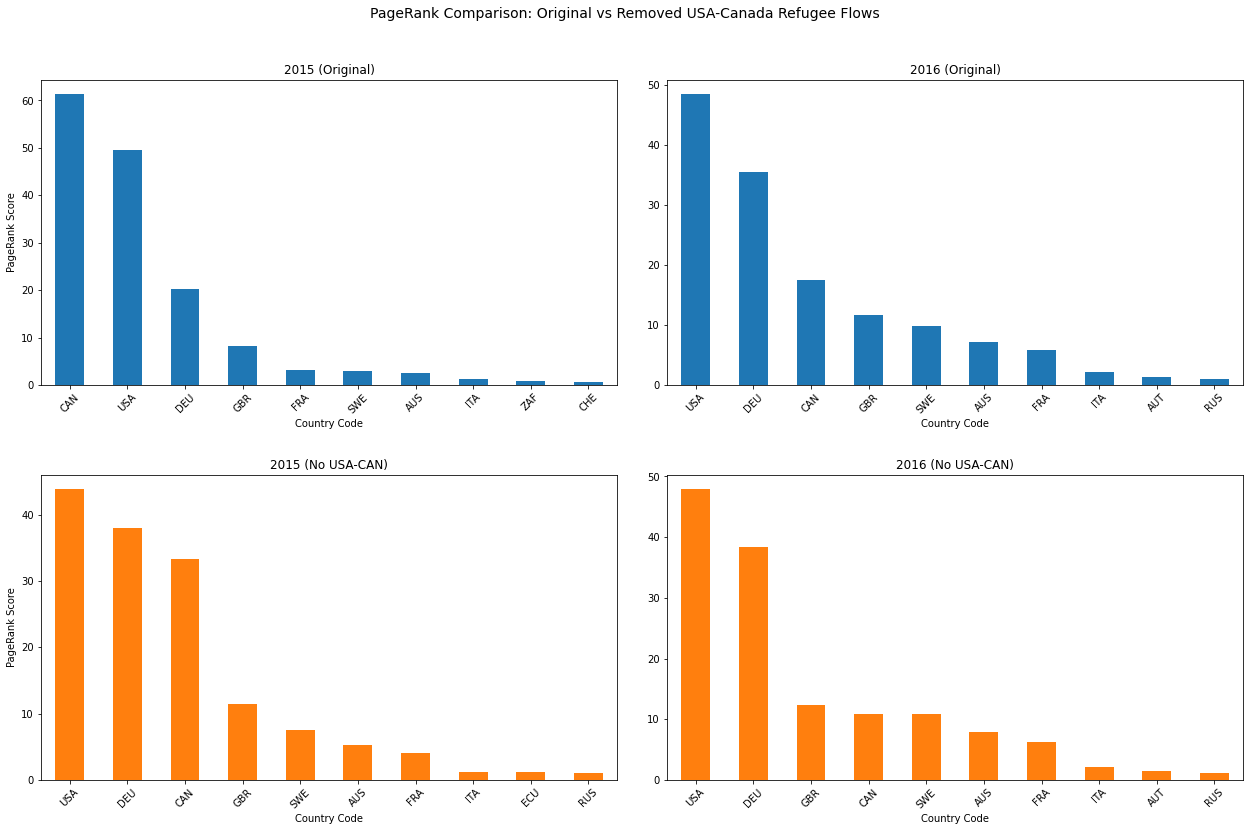

In [101]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

#original
pagerank_2015[:10].plot.bar(x='iso_code', y='pagerank_score', ax=axes[0,0], color='#1f77b4', legend=False)
pagerank_2016[:10].plot.bar(x='iso_code', y='pagerank_score', ax=axes[0,1], color='#1f77b4', legend=False)

#without USA-Canada connection
no_usa_2015[:10].plot.bar(x='iso_code', y='pagerank_score', ax=axes[1,0], color='#ff7f0e', legend=False)
no_usa_2016[:10].plot.bar(x='iso_code', y='pagerank_score', ax=axes[1,1], color='#ff7f0e', legend=False)

#formatting
titles = [
    ['2015 (Original)', '2016 (Original)'],
    ['2015 (No USA-CAN)', '2016 (No USA-CAN)']
]

for i in range(2):
    for j in range(2):
        axes[i,j].set_title(titles[i][j], fontsize=12)
        axes[i,j].tick_params(axis='x', rotation=45)
        axes[i,j].set_xlabel('Country Code')
        if j == 0:
            axes[i,j].set_ylabel('PageRank Score')

plt.suptitle("PageRank Comparison: Original vs Removed USA-Canada Refugee Flows", y=0.98, fontsize=14)
plt.tight_layout(pad=3.0)
plt.show()

**Interpretation**

Notice that after removing the USA-CAN link, the USA score decreases slightly, but it moves into the first place for 2015.
Also notice that Germany's score increases significantly -- the USA no longer "wastes" its influence on Canada.

For 2016, the order of the countries is relatively similar, though GBR overtakes Canada.

Also, even without the node change, 2016 Germany ranks higher than Canada because of the 2015-2016 Syrian Crisis.
https://www.bbc.com/news/world-europe-34131911



# Betweenness Centrality

We run a similar function but use the Betweenness Centrality algorithm over many years.

We interpret a high-betweeness country as a control point or bridge since it lies in the paths of many countries.

In [77]:
def analyze_refugee_betweenness(year, refugee_min=1):
    """
    betweenness centrality for specific year
    Parameters:
    - year: Dataset year to analyze
    - refugee_min: Minimum refugee count to include (default 1)
    Returns: pandas dataframe with betweenness centrality results
    """
    create_graph(year, refugee_min=refugee_min)
    session.run("CALL gds.graph.drop('betweenness_graph', false) YIELD graphName")
    
    #keep direction
    #undirected graph.
    orientation = 'NATURAL'
    project_query = f"""
    CALL gds.graph.project(
        'betweenness_graph',
        'Country',
        {{REFUGEE_FLOW: {{
            orientation: '{orientation}',
            properties: 'refugees'
        }}}}
    )
    """
    session.run(project_query)
    
    #betweenness centrality w/ refugees as weights
    betweenness_query = """
    CALL gds.betweenness.stream('betweenness_graph', {
    relationshipWeightProperty: 'refugees'
    })
    YIELD nodeId, score
    RETURN 
        gds.util.asNode(nodeId).name AS country,
        gds.util.asNode(nodeId).iso_code as iso_code,
        score AS betweenness_score
    ORDER BY betweenness_score DESC
    """
    return my_neo4j_run_query_pandas(betweenness_query)

In [78]:
example_betweenness = analyze_refugee_betweenness(2022, refugee_min=1)
example_betweenness.head()

,country,iso_code,betweenness_score
0,Russian Federation,RUS,13190.597619
1,Poland,POL,7711.029762
2,Pakistan,PAK,5814.016667
3,United States of America,USA,4360.835714
4,Egypt,EGY,3857.602381


In [80]:
betweenness_df = pd.DataFrame()

#collect betweenness data for every year
for year in range(2010, 2025):
    year_df = analyze_refugee_betweenness(year, refugee_min=1)
    year_df['year'] = year
    betweenness_df = pd.concat([betweenness_df, year_df], ignore_index=True)

#change format to have years as column
# can change index='country', but kept it at 'iso_code' for better formatting on graphs.
betweenness_df = betweenness_df.pivot(index='iso_code', columns='year', values='betweenness_score')

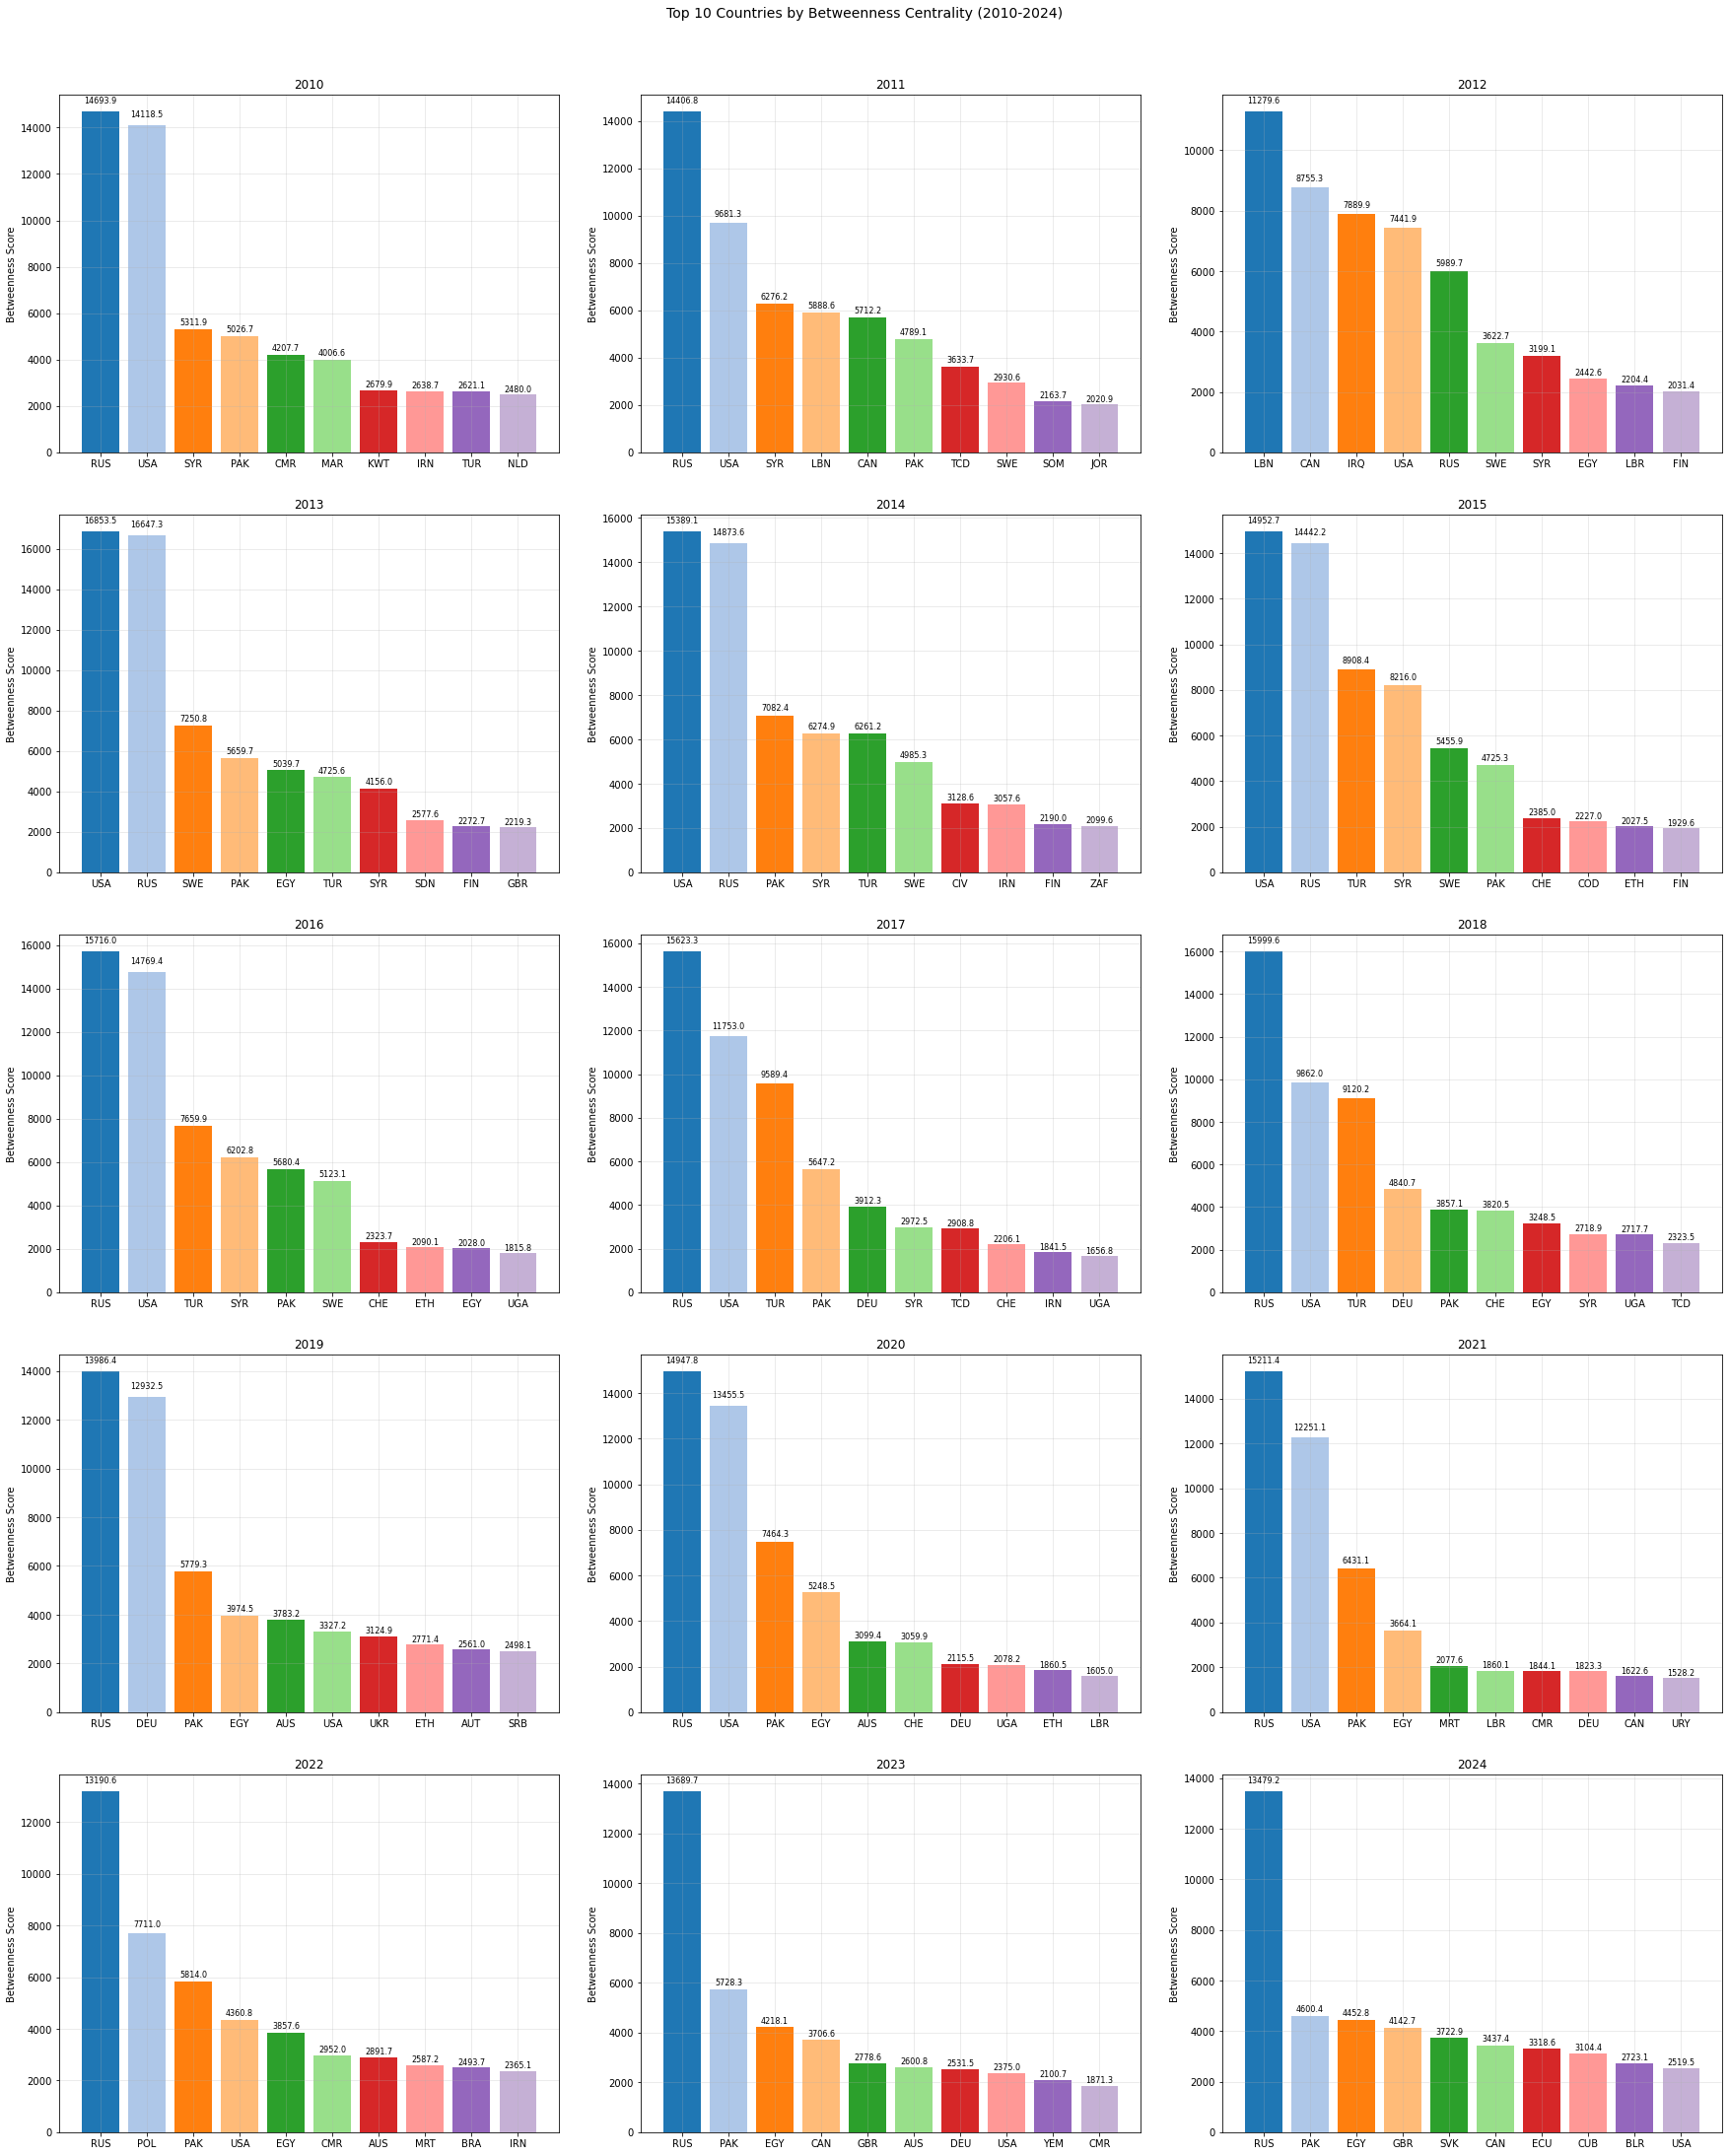

In [81]:
fig, axes = plt.subplots(5, 3, figsize=(25, 30))
years = betweenness_df.columns
axes = axes.flatten()

cmap = plt.cm.get_cmap('tab20', 20)

for idx, year in enumerate(years):
    ax = axes[idx]
    
    top_10 = betweenness_df[year].sort_values(ascending=False).head(10)
    
    bars = ax.bar(top_10.index, top_10.values, color=cmap(range(10)))
    
    ax.set_title(f'{year}', fontsize=12)
    ax.set_ylabel('Betweenness Score', fontsize=10)
    ax.tick_params(axis='x')
    ax.grid(alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height*1.02,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout(pad=3.0)
plt.suptitle('Top 10 Countries by Betweenness Centrality (2010-2024)', y=1.02, fontsize=14)
plt.show()

**Interpretation**

Surprisingly, Russia remains high on the betweenness centrality. We might attribute this to its geographic location since it has access to large parts of Asia, the Middle East, and Eastern Europe.

Notice in 2012, Lebanon becomes the number 1 country. This might be explained by in 2012, Lebanon experienced a significant increase in Syrian refugees due to its geographic location.

**Examining Betweenness Centrality for Select Countries**

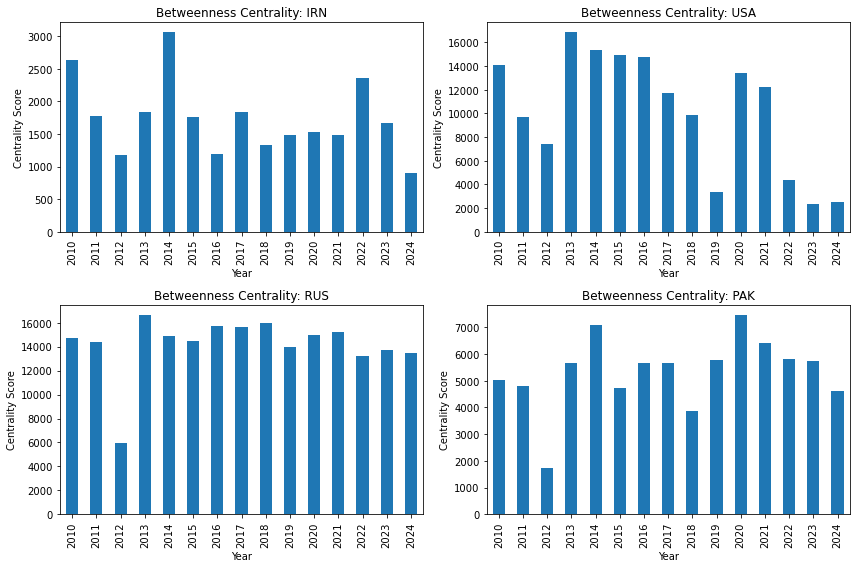

In [91]:
countries = ['IRN', 'USA', 'RUS', 'PAK']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for ax, country in zip(axes.flatten(), countries):
    betweenness_df.loc[country].plot.bar(ax=ax)
    ax.set_title(f"Betweenness Centrality: {country}")
    ax.set_ylabel("Centrality Score")
    ax.set_xlabel("Year")
    ax.tick_params(axis='x')

plt.tight_layout()
plt.show()


**Interpretation**

Notice that USA's score falls off around 2018. The other countries tend to be more consistent.

# Louvain Modularity

We run a similar function, but run the Louvain Modularity algorithm to identify clusters of countries with dense refugee connections.

This requires additional parameters
- max_iterations: maximum number of passes through the network
- tolerance: minimum change threshold for convergence
- include_intermediate: return intermediate communities (set this to false by default)

We interpret communities determined by Louvain Modularity as crisis regions and their destinations.

Since there are no "scores" with this algorithm, we choose to run it only for 2016, 2022.

In [39]:
def analyze_refugee_communities(year, refugee_min=1,
                               include_intermediate=False, max_iterations=10,
                               tolerance=0.0001):
    """
    Analyze refugee flow communities using Louvain Modularity
    Parameters:
    - year: Dataset year to analyze
    - refugee_min: minimum refugee count to include (default 1)
    - direction: 'natural' (origin->asylum) or 'reverse' (asylum->origin)
    - include_intermediate: Return intermediate communities (default False)
    - max_iterations: max passes through network (default 10)
    - tolerance: minimum change threshold for convergence (default 0.0001)
    Returns pandas dataframe with community assignments.
    """
    create_graph(year, refugee_min=refugee_min)
    session.run("CALL gds.graph.drop('community_graph', false) YIELD graphName")
    
    project_query = f"""
    CALL gds.graph.project(
        'community_graph',
        'Country',
        {{REFUGEE_FLOW: {{
            orientation: 'NATURAL',
            properties: 'refugees'
        }}}}
    )
    """
    session.run(project_query)
    
    louvain_query = f"""
    CALL gds.louvain.stream('community_graph', {{
        maxIterations: {max_iterations},
        tolerance: {tolerance},
        includeIntermediateCommunities: {'true' if include_intermediate else 'false'},
        relationshipWeightProperty: 'refugees'
    }})
    YIELD nodeId, communityId{', intermediateCommunityIds' if include_intermediate else ''}
    RETURN 
        gds.util.asNode(nodeId).name AS country,
        gds.util.asNode(nodeId).iso_code AS iso_code,
        communityId AS community{' , intermediateCommunityIds AS intermediate_communities' if include_intermediate else ''}
    ORDER BY community, country
    """
    
    return my_neo4j_run_query_pandas(louvain_query)

In [51]:
# Running 

df_comms_2016 = analyze_refugee_communities(
    year=2016,
    include_intermediate=True,
    tolerance=0.00001
)

df_comms_2022 = analyze_refugee_communities(
    year=2022,
    include_intermediate=True,
    tolerance=0.00001
)

### 2016 Louvain Modularity

Analyzing the top 5 largest communities

Community Number || Number of members

In [52]:
top_comms = df_comms_2016.groupby('community').size().sort_values(ascending=False)
top_comms

community
186    174
197     11
196     10
4        1
92       1
99       1
152      1
195      1
200      1
dtype: int64

In [55]:
# 1.
df_comms_2016[df_comms_2016['community'] == 186]

,country,iso_code,community,intermediate_communities
4,Albania,ALB,186,"[90, 170, 189, 186]"
5,Algeria,DZA,186,"[90, 170, 189, 186]"
6,Angola,AGO,186,"[90, 170, 189, 186]"
7,Antigua and Barbuda,ATG,186,"[90, 170, 189, 186]"
8,Argentina,ARG,186,"[90, 170, 189, 186]"
...,...,...,...,...
173,Venezuela (Bolivarian Republic of),VEN,186,"[90, 170, 189, 186]"
174,Viet Nam,VNM,186,"[90, 170, 189, 186]"
175,Yemen,YEM,186,"[90, 170, 189, 186]"
176,Zambia,ZMB,186,"[90, 170, 189, 186]"


In [56]:
# 2.
df_comms_2016[df_comms_2016['community'] == 197]

,country,iso_code,community,intermediate_communities
189,Afghanistan,AFG,197,"[2, 199, 197, 197]"
190,"China, Hong Kong SAR",HKG,197,"[181, 199, 197, 197]"
191,Fiji,FJI,197,"[181, 199, 197, 197]"
192,Indonesia,IDN,197,"[181, 199, 197, 197]"
193,Luxembourg,LUX,197,"[197, 197, 197, 197]"
194,Maldives,MDV,197,"[181, 199, 197, 197]"
195,Nauru,NRU,197,"[199, 199, 197, 197]"
196,Pakistan,PAK,197,"[2, 199, 197, 197]"
197,Papua New Guinea,PNG,197,"[181, 199, 197, 197]"
198,Timor-Leste,TLS,197,"[181, 199, 197, 197]"


In [59]:
# 3.
df_comms_2016[df_comms_2016['community'] == 196]

,country,iso_code,community,intermediate_communities
179,Chad,TCD,196,"[24, 24, 103, 196]"
180,Cyprus,CYP,196,"[103, 103, 103, 196]"
181,Eritrea,ERI,196,"[24, 24, 103, 196]"
182,Liechtenstein,LIE,196,"[196, 196, 196, 196]"
183,Mali,MLI,196,"[24, 24, 103, 196]"
184,Mauritania,MRT,196,"[29, 24, 103, 196]"
185,Niger,NER,196,"[24, 24, 103, 196]"
186,Nigeria,NGA,196,"[24, 24, 103, 196]"
187,Sudan,SDN,196,"[24, 24, 103, 196]"
188,Western Sahara,ESH,196,"[23, 24, 103, 196]"


In [60]:
# 4.
df_comms_2016[df_comms_2016['community'] == 4]

,country,iso_code,community,intermediate_communities
0,Sint Maarten (Dutch part),SXM,4,"[4, 4, 4, 4]"


In [62]:
#5.
df_comms_2016[df_comms_2016['community'] == 92]

,country,iso_code,community,intermediate_communities
1,Andorra,AND,92,"[92, 92, 92, 92]"


**2016 Louvain Modularity Analysis**

It seems like most countries fall under one large community, indicating how interconnected the world is.

The second largest community contains an interesting combination of countries like Afghanistan, Pakistan, and Indonesia, but also has tiny countries like Nauru and Maldives.

The third largest community makes more sense, consisting mainly of western and northern African countries. 

The remaining communities seem to be tiny countries with little influence.

### 2022 Louvain Modularity

Community Number || Number of members

In [70]:
top_comms_2022 = df_comms_2022.groupby('community').size().sort_values(ascending=False)
top_comms_2022

community
12     175
173     10
204      8
172      5
191      3
8        1
10       1
13       1
109      1
124      1
182      1
dtype: int64

In [71]:
#1. 
df_comms_2022[df_comms_2022['community'] == 12]

,country,iso_code,community,intermediate_communities
2,Afghanistan,AFG,12,"[130, 12]"
3,Albania,ALB,12,"[130, 12]"
4,Algeria,DZA,12,"[130, 12]"
5,Angola,AGO,12,"[130, 12]"
6,Anguilla,AIA,12,"[130, 12]"
...,...,...,...,...
172,Venezuela (Bolivarian Republic of),VEN,12,"[130, 12]"
173,Viet Nam,VNM,12,"[130, 12]"
174,Western Sahara,ESH,12,"[130, 12]"
175,Zambia,ZMB,12,"[130, 12]"


In [72]:
#2. 
df_comms_2022[df_comms_2022['community'] == 173]

,country,iso_code,community,intermediate_communities
185,Andorra,AND,173,"[24, 173]"
186,Chad,TCD,173,"[24, 173]"
187,Denmark,DNK,173,"[173, 173]"
188,Eritrea,ERI,173,"[24, 173]"
189,Ethiopia,ETH,173,"[24, 173]"
190,Kenya,KEN,173,"[24, 173]"
191,Somalia,SOM,173,"[24, 173]"
192,South Sudan,SSD,173,"[24, 173]"
193,Sudan,SDN,173,"[24, 173]"
194,Yemen,YEM,173,"[24, 173]"


In [73]:
#3. 
df_comms_2022[df_comms_2022['community'] == 204]

,country,iso_code,community,intermediate_communities
199,Burkina Faso,BFA,204,"[41, 204]"
200,Cameroon,CMR,204,"[41, 204]"
201,Central African Rep.,CAF,204,"[41, 204]"
202,Finland,FIN,204,"[204, 204]"
203,Mali,MLI,204,"[41, 204]"
204,Mauritania,MRT,204,"[41, 204]"
205,Niger,NER,204,"[41, 204]"
206,Nigeria,NGA,204,"[41, 204]"


In [74]:
#4. 
df_comms_2022[df_comms_2022['community'] == 172]

,country,iso_code,community,intermediate_communities
180,Cote d'Ivoire,CIV,172,"[47, 172]"
181,Cyprus,CYP,172,"[172, 172]"
182,Ghana,GHA,172,"[47, 172]"
183,Liberia,LBR,172,"[47, 172]"
184,Togo,TGO,172,"[47, 172]"


In [75]:
#5. 
df_comms_2022[df_comms_2022['community'] == 191]

,country,iso_code,community,intermediate_communities
196,Iceland,ISL,191,"[191, 191]"
197,Libya,LBY,191,"[193, 191]"
198,Malta,MLT,191,"[193, 191]"


**Interpretation**

Similar to 2016, most countries in 2022 fall into a single large community. However, Afghanistan now joins the larger community.

The second largest group appears to be African countries near Sudan, which we can attribute to the emerging Sudan conflict.

The third largest group appears to be western African countries combined with Finland.

The number 5 community is also interesting - consisting of Iceland, Libya and Malta. We can probably attribute this to these countries having very sparse/weak connections in the network, so the algorithm groups them because they have little connections anywhere else.